In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec

from wordcloud import WordCloud,STOPWORDS
import re
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
import spacy
import os

for reference https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [2]:
%matplotlib inline

In [3]:
nlp = spacy.load("en_core_web_sm")
# nlp=spacy.load('en')

In [4]:
 print('\n'.join(os.listdir('NIPS papers')))

authors.csv
database.sqlite
papers.csv
paper_authors.csv


In [5]:
authors = pd.read_csv("./NIPS papers/authors.csv")
paper_authors = pd.read_csv("./NIPS papers/paper_authors.csv")
papers = pd.read_csv("./NIPS papers/papers.csv")

# Number of Papers published every year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

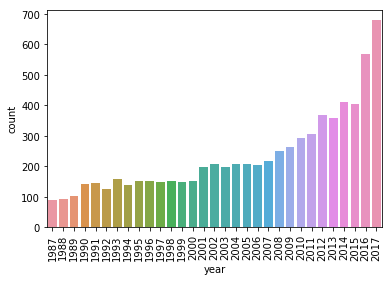

In [6]:
g = sns.countplot(papers.year)
plt.xticks(rotation=90)

In [7]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# Number of Papers published every year

In [8]:
authors_new = authors.rename(columns = {'id':'author_id'})
paper_authors_new = pd.merge(paper_authors, authors_new, on='author_id', how='left')

In [9]:
authors_new.head()

,author_id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


In [10]:
paper_authors_new.head()

,id,paper_id,author_id,name
0,1,63,94,Yaser S. Abu-Mostafa
1,2,80,124,Joshua Alspector
2,3,80,125,Robert B. Allen
3,4,80,126,Victor Hu
4,5,80,127,Srinagesh Satyanarayana


Text(0.5, 1.0, 'Highest number of papers published authors')

<Figure size 1296x432 with 0 Axes>

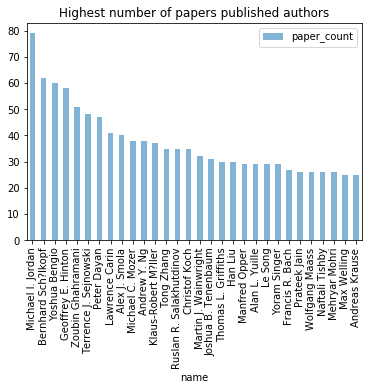

In [11]:
author_paper_count = paper_authors[["author_id","paper_id"]].groupby("author_id").count().sort_values(by="paper_id",ascending=False).reset_index()
author_paper_count = author_paper_count.rename(columns = {'paper_id':'paper_count'})
authors_new = authors.rename(columns = {'id':'author_id'})
author_paper_count = pd.merge(author_paper_count, authors_new, on="author_id",how="left")
top30_authorsbycount = author_paper_count.iloc[:,1:].head(30)
plt.figure( figsize =(18,6))
top30_authorsbycount.plot(x="name",y ="paper_count", kind='bar', alpha=0.55)
plt.title("Highest number of papers published authors")

In [12]:
paper_authors[["author_id","paper_id"]].head()

,author_id,paper_id
0,94,63
1,124,80
2,125,80
3,126,80
4,127,80


In [13]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# Tokenization

In [14]:
papers['doc_title'] = papers['title'].apply(lambda x: nlp(x))


In [15]:
papers['doc_title_tokenized']=papers['doc_title'].apply(lambda doc: [token.orth_ for token in doc if not token.is_punct | token.is_space])
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,doc_title,doc_title_tokenized
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"(Self, -, Organization, of, Associative, Datab...","[Self, Organization, of, Associative, Database..."
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,"(A, Mean, Field, Theory, of, Layer, IV, of, Vi...","[A, Mean, Field, Theory, of, Layer, IV, of, Vi..."
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"(Storing, Covariance, by, the, Associative, Lo...","[Storing, Covariance, by, the, Associative, Lo..."
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"(Bayesian, Query, Construction, for, Neural, N...","[Bayesian, Query, Construction, for, Neural, N..."
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","(Neural, Network, Ensembles, ,, Cross, Validat...","[Neural, Network, Ensembles, Cross, Validation..."


In [64]:
papers['doc_title_tokenized_str']=papers['doc_title_tokenized'].apply(lambda x:' '.join(i for i in x))

In [66]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,doc_title,doc_title_tokenized,doc_title_tokenized_str
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"(Self, -, Organization, of, Associative, Datab...","[Self, Organization, of, Associative, Database...",Self Organization of Associative Database and ...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,"(A, Mean, Field, Theory, of, Layer, IV, of, Vi...","[A, Mean, Field, Theory, of, Layer, IV, of, Vi...",A Mean Field Theory of Layer IV of Visual Cort...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"(Storing, Covariance, by, the, Associative, Lo...","[Storing, Covariance, by, the, Associative, Lo...",Storing Covariance by the Associative Long Ter...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"(Bayesian, Query, Construction, for, Neural, N...","[Bayesian, Query, Construction, for, Neural, N...",Bayesian Query Construction for Neural Network...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","(Neural, Network, Ensembles, ,, Cross, Validat...","[Neural, Network, Ensembles, Cross, Validation...",Neural Network Ensembles Cross Validation and ...


# Wordcloud

In [16]:
a=" ".join([j for i in papers['doc_title_tokenized'] for j in i])

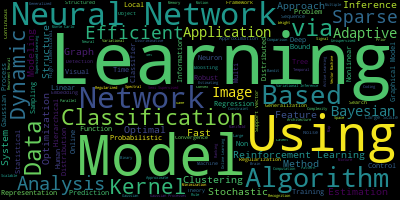

In [23]:
obj = wordcloud.WordCloud()
obj.generate(a)

obj.to_image()

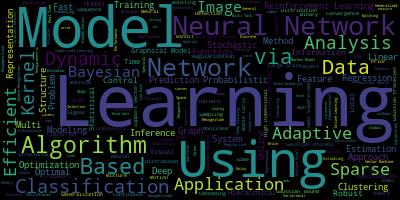

In [24]:
obj = wordcloud.WordCloud()
obj.generate(a)

obj.to_image()

In [70]:
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

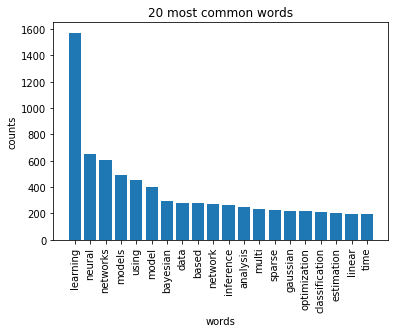

In [71]:
count_vectorizer = CountVectorizer(stop_words='english') 

count_data = count_vectorizer.fit_transform(papers['doc_title_tokenized_str'])

plot_20_most_common_words(count_data, count_vectorizer)

In [74]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [77]:
number_topics = 10
number_words = 5

lda = LDA(n_components=number_topics)
lda.fit(count_data)

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
boosting matching based using images

Topic #2:
analysis learning component models bayesian

Topic #3:
bayesian gradient model classification decision

Topic #4:
inference models estimation gaussian variational

Topic #5:
networks neural learning recurrent deep

Topic #6:
optimization sparse convex stochastic linear

Topic #7:
spike using processes fast analog

Topic #8:
learning reinforcement multi supervised multiple

Topic #9:
learning models markov data analysis

Topic #10:
recognition based network neural vector
